In [1]:
# Importing Libraries

from textblob import TextBlob
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import json

from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Authentication
# Make a config.json file from config.json.example
# Get the keys from https://developer.twitter.com

with open("config.json") as token:
    key=json.load(token)
consumerKey = key["consumerKey"]
consumerSecret = key["consumerSecret"]
accessToken = key["accessToken"]
accessTokenSecret = key["accessTokenSecret"]
bearerToken = key["bearerToken"]

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.Client(bearerToken,auth,wait_on_rate_limit=True)

In [3]:
#Sentiment Analysis

def percentage(part,whole):
    return 100 * float(part)/float(whole) 

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))


tweets = tweepy.Paginator(api.search_recent_tweets, query=keyword,).flatten(limit=noOfTweet)
positive  = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = round(positive,1)
negative = round(negative,1)
neutral = round(neutral,1)

print("Keyword : ",keyword)
print("Number of tweets to analyze",noOfTweet)

Please enter keyword or hashtag to search: Messi
Please enter how many tweets to analyze: 1000


In [4]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  1000
positive number:  412
negative number:  175
neutral number:  413


In [5]:
#Removing Duplicate Tweets
tweet_list.drop_duplicates(inplace = True)

In [6]:
tweet_list

,0
0,RT @CrewsMat10: Cristiano Ronaldo commenting “...
1,RT @Waffirian_: Dear Messi FC\n\nThe way to sp...
2,"@Enz00beats 🥺 ""faites entrer Léo Messi""..."
3,RT @ObongRoviel: I don’t think Messi has openl...
4,RT @Iaurnirvana: lionel messi? yo solo conozco...
...,...
989,Le Parc des Princes s'apprête à fêter le 7e #B...
993,@alf19bcn A mi el Messi no em va dir mai que n...
995,RT @messi30Goat_: Cry @Evra where you were 201...
996,RT @alimo_philip: 📅 12 Years Ago Today: \n\n🇦🇷...


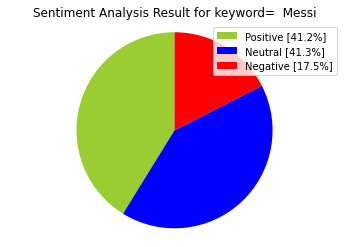

In [7]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

In [8]:
#Cleaning Text (RT, Punctuation etc)
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,RT @CrewsMat10: Cristiano Ronaldo commenting “...,cristiano ronaldo commenting facts under a ...
1,RT @Waffirian_: Dear Messi FC\n\nThe way to sp...,dear messi fc the way to spell messi s goat ...
2,"@Enz00beats 🥺 ""faites entrer Léo Messi""...",faites entrer l o messi
3,RT @ObongRoviel: I don’t think Messi has openl...,i don t think messi has openly disrespected r...
4,RT @Iaurnirvana: lionel messi? yo solo conozco...,lionel messi yo solo conozco a mateo messi
5,RT @CrewsMat10: Casillas left Messi out of his...,casillas left messi out of his top 3 in his v...
6,@Skouille_ @memphissinho9 Humainement il est s...,humainement il est sympathique c est just...
7,@ActuFoot_ Messi has 4 ballon d'or in my book ...,messi has 4 ballon d or in my book not 7
8,RT @Yemihazan: If only Messi had that ibrahomo...,if only messi had that ibrahomovic attitude ...
9,@elchiringuitotv Tampoco es justo que 1 tío q ...,tampoco es justo que 1 t o q ha sido condena...


In [9]:
#Calculating Negative, Positive, Neutral and Compound values

tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @CrewsMat10: Cristiano Ronaldo commenting “...,cristiano ronaldo commenting facts under a ...,0.0,0.1,neutral,0.000,1.000,0.000,0.0000
1,RT @Waffirian_: Dear Messi FC\n\nThe way to sp...,dear messi fc the way to spell messi s goat ...,0.2,0.2,positive,0.000,0.703,0.297,0.6705
2,"@Enz00beats 🥺 ""faites entrer Léo Messi""...",faites entrer l o messi,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
3,RT @ObongRoviel: I don’t think Messi has openl...,i don t think messi has openly disrespected r...,0.0,0.5,positive,0.142,0.711,0.147,0.0258
4,RT @Iaurnirvana: lionel messi? yo solo conozco...,lionel messi yo solo conozco a mateo messi,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
5,RT @CrewsMat10: Casillas left Messi out of his...,casillas left messi out of his top 3 in his v...,0.1,0.3,positive,0.000,0.927,0.073,0.2023
6,@Skouille_ @memphissinho9 Humainement il est s...,humainement il est sympathique c est just...,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
7,@ActuFoot_ Messi has 4 ballon d'or in my book ...,messi has 4 ballon d or in my book not 7,0.0,0.0,neutral,0.000,1.000,0.000,0.0000
8,RT @Yemihazan: If only Messi had that ibrahomo...,if only messi had that ibrahomovic attitude ...,0.0,1.0,negative,0.150,0.850,0.000,-0.5719
9,@elchiringuitotv Tampoco es justo que 1 tío q ...,tampoco es justo que 1 t o q ha sido condena...,0.2,0.2,positive,0.000,0.873,0.127,0.5859


In [10]:
#Function for counting values in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [11]:
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
neutral,244,42.43
positive,222,38.61
negative,109,18.96


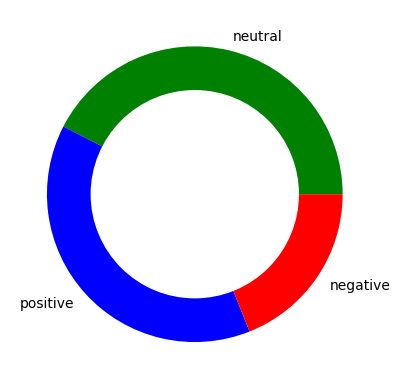

In [12]:
pichart = count_values_in_column(tw_list,"sentiment")
names= pichart.index
size=pichart["Percentage"]

my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
#Calculating tweet's length and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))

In [14]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,116.47
neutral,92.95
positive,122.56


In [15]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,21.50
neutral,17.05
positive,22.44


In [16]:
#Most Used Words
most_used_words = pd.DataFrame(Counter(" ".join(tw_list["text"]).split()).most_common(),columns=["word","count"])
for i in most_used_words["word"]:
    if len(i)<4:
        most_used_words= most_used_words[most_used_words.word != i]
most_used_words.reset_index(drop=True,inplace=True)
most_used_words.head(10)

,word,count
0,messi,584
1,ballon,133
2,ronaldo,129
3,cristiano,82
4,that,68
5,lionel,63
6,this,54
7,with,38
8,lewandowski,31
9,than,30
